In [1]:
import os
from os.path import join, abspath

import sys
sys.path.append(abspath('..'))

import numpy as np
import pandas as pd

from utils import get_dataset, get_target, Preprocessor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.simplefilter("ignore")

SEED = 0xBAD_5EED
np.random.seed(SEED)

EPS = 1e-3
DATA_PATH = join(os.getcwd(), '..', 'data', 'events')

In [2]:
event_keys = os.listdir(DATA_PATH)
event_keys = [ek for ek in event_keys if ek.isdigit()]
event_dirs = [join(DATA_PATH, ek) for ek in event_keys]
len(event_dirs)

6

In [3]:
teams, players = get_dataset(event_dirs)
teams = teams.dropna()
players = players.dropna()

Player with id=20170 has no matching team_id.
Player with id=13602 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=18163 has no matching team_id.
Player with id=21217 has no matching team_id.
Player with id=16848 has no matching team_id.
Player with id=21816 has no matching team_id.
Player with id=13618 has no matching team_id.
Player with id=15573 has no matching team_id.
Player with id=19164 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=11777 has no matching team_id.


In [4]:
date_cols = ["start_time", "end_time", "start_at", "ends_at"]
team_drop_cols = ["event_fil", "ranking_fil",
                  "is_lan", "is_qual", "prize_pool", "duration", "event_id"]
team_drop_cols += [f"player_id_{i + 1}" for i in range(5)]

In [5]:
df = players.drop(date_cols, axis=1).merge(teams.drop(team_drop_cols + date_cols, axis=1), on="team_id").drop_duplicates()
df["target"] = get_target(df.expected_pts_target, df.wr_target)
df

,rating,dpr,kast,impact,adr,kpr,total_kills,hs,kd,gdr,...,avg_place,winrate,avg_match_intensity,avg_win_intensity,avg_loss_intensity,winstreak,matches_played,wr_target,team_name,target
0,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,5.281250,0.591837,1.453861,1.989617,0.677014,0,49,0.00,betboom,-6.50
1,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,4.875000,0.500000,1.062761,1.409098,0.716424,2,16,0.00,betboom,-6.50
2,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,4.800000,0.512821,1.373098,2.027451,0.684306,0,39,0.00,betboom,-6.50
3,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,4.875000,0.619048,1.160991,1.434571,0.716424,4,21,0.00,betboom,-6.50
4,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,14.500000,0.600000,0.977839,1.183785,0.668919,1,5,0.00,betboom,-6.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631687,1.03,0.70,70.8,1.09,70.8,0.66,150,61.3,0.95,4.3,...,8.333333,0.473684,1.150189,1.670708,0.681721,0,19,0.25,fnatic,-7.75
631688,1.03,0.70,70.8,1.09,70.8,0.66,150,61.3,0.95,4.3,...,14.500000,0.600000,1.564998,2.133971,0.711538,2,5,0.25,fnatic,-7.75
631754,1.03,0.70,70.8,1.09,70.8,0.66,150,61.3,0.95,4.3,...,8.150000,0.538462,1.421059,2.080737,0.651434,1,26,0.25,fnatic,-7.75
631755,1.03,0.70,70.8,1.09,70.8,0.66,150,61.3,0.95,4.3,...,8.333333,0.473684,1.150189,1.670708,0.681721,0,19,0.25,fnatic,-7.75


In [6]:
train_events = [7755, 7440, 7437, 6976, 7553]
test_events = [int(ek) for ek in event_keys if int(ek) not in train_events]

In [7]:
target_col = ["target"]

drop_cols = ["event_id", "player_id", "team_id", "team_name", "player_name", # meta
             "duration", "maps_played", "kpr",                               # correlated
             "wr_target", "expected_pts_target",                             # unknown values
             "event_fil", "ranking_fil"] + target_col

cat_cols = ["ranking_fil"]
bin_cols = ["has_roster_change", "is_lan", "is_qual", "is_awp"]

df[bin_cols] = df[bin_cols].astype(np.int32)
df[target_col] = df[target_col].astype(np.float64)

In [8]:
train = df[df.event_id.isin(train_events)].sample(frac=1).reset_index(drop=True)
test = df[df.event_id.isin(test_events)].sample(frac=1).reset_index(drop=True)

X_train, y_train = train.drop(drop_cols, axis=1), train[target_col].astype(np.float64)
X_test, y_test = test.drop(drop_cols, axis=1), test[target_col].astype(np.float64)

# CatBoost

In [9]:
model = CatBoostRegressor(cat_features=bin_cols, random_seed=SEED)

In [10]:
model.fit(X_train, y_train, verbose=True)
y_preds = model.predict(X_test)
y_preds = y_preds.reshape((len(y_preds), 1))

Learning rate set to 0.065815
0:	learn: 8.4868585	total: 52.3ms	remaining: 52.2s
1:	learn: 8.2969830	total: 54.2ms	remaining: 27.1s
2:	learn: 8.1298728	total: 56.2ms	remaining: 18.7s
3:	learn: 7.9771948	total: 57.9ms	remaining: 14.4s
4:	learn: 7.8298353	total: 59.6ms	remaining: 11.9s
5:	learn: 7.6961947	total: 61.3ms	remaining: 10.2s
6:	learn: 7.5785167	total: 63ms	remaining: 8.93s
7:	learn: 7.4637755	total: 64.6ms	remaining: 8.01s
8:	learn: 7.3725070	total: 66.4ms	remaining: 7.31s
9:	learn: 7.2747374	total: 68.1ms	remaining: 6.74s
10:	learn: 7.1820491	total: 69.8ms	remaining: 6.28s
11:	learn: 7.1035843	total: 71.6ms	remaining: 5.89s
12:	learn: 7.0192197	total: 73.3ms	remaining: 5.56s
13:	learn: 6.9446696	total: 74.9ms	remaining: 5.28s
14:	learn: 6.8621992	total: 76.8ms	remaining: 5.04s
15:	learn: 6.8036567	total: 78.4ms	remaining: 4.82s
16:	learn: 6.7287524	total: 80.2ms	remaining: 4.64s
17:	learn: 6.6644120	total: 82ms	remaining: 4.47s
18:	learn: 6.6126535	total: 83.6ms	remaining: 4.

In [11]:
from utils import validate

validate(y_test.values, y_preds)

,mse,mae,ndcg
0,25.613738,4.027034,0.937595


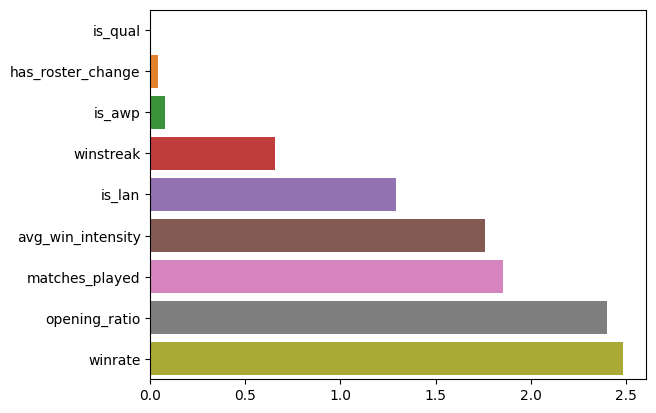

In [12]:
idx = np.argsort(model.feature_importances_)[:9]
sns.barplot(x=model.feature_importances_[idx], y=np.array(model.feature_names_)[idx]);

In [13]:
final = test[target_col + ["team_name", "player_name"]]
final["pred_target"] = y_preds
final = final.groupby(["player_name"]).max()
final.sort_values(["target"], ascending=False).head(10)

,target,team_name,pred_target
player_name,,,
donk,22.750000,spirit,22.130953
torzsi,19.000000,mouz,15.687211
m0nesy,18.000000,g2,13.630267
brollan,17.750000,mouz,13.231114
sh1ro,17.000000,spirit,16.079204
jimpphat,17.000000,mouz,16.574569
flamez,13.666667,vitality,9.970130
jl,13.250000,natus-vincere,8.512050
spinx,12.833333,vitality,22.750000


# Random Forest

In [14]:
rf = RandomForestRegressor(n_estimators=100, max_depth=9, random_state=SEED)

param_grid = {
    'n_estimators': [50, 70, 90, 120, 150],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

searcher = RandomizedSearchCV(
    n_iter=10,
    estimator=rf,
    param_distributions=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

In [15]:
searcher.fit(X_train, y_train.values.ravel())
y_preds = searcher.predict(X_test)
y_preds = y_preds.reshape((len(y_preds), 1))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [16]:
validate(y_test.values, y_preds)

,mse,mae,ndcg
0,28.777592,4.313006,0.917716


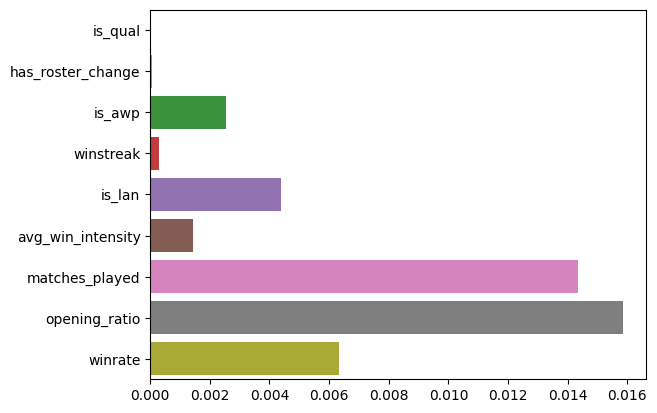

In [17]:
idx = np.argsort(model.feature_importances_)[:9]
sns.barplot(x=searcher.best_estimator_.feature_importances_[idx], y=np.array(searcher.best_estimator_.feature_names_in_)[idx]);

In [18]:
final = test[target_col + ["team_name", "player_name"]]
final["pred_target"] = y_preds
final = final.groupby(["player_name"]).max()
final.sort_values(["target"], ascending=False).head(10)

,target,team_name,pred_target
player_name,,,
donk,22.750000,spirit,20.402705
torzsi,19.000000,mouz,9.659936
m0nesy,18.000000,g2,12.367473
brollan,17.750000,mouz,7.881406
sh1ro,17.000000,spirit,9.528362
jimpphat,17.000000,mouz,22.248344
flamez,13.666667,vitality,7.799183
jl,13.250000,natus-vincere,21.109252
spinx,12.833333,vitality,22.570543
